# Labeling all data

In [358]:
import os
import json

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

In [47]:
def preprocess(obj):
    obj["_id"] = obj["_id"]["$oid"]
    
    user = [
        "id",
        'screen_name',
        'statuses_count',
        "favourites_count",
        "followers_count",
        "friends_count"
    ]
    
    temp = {
        "id": obj["_id"],
        "text": obj["text"],
        "created_at": obj["created_at"]
    }
    
    for key in user:
        temp["user_"+key] = obj["user"][key]
    
    try:
        temp["geo"] = obj["geo"]
    except:
        temp["geo"] = None
        
    try:
        temp["place_country"] = obj["place"]["country"]
        temp["place_fullname"]= obj["place"]["full_name"]
    except:
        temp["place_country"] = None
        temp["place_fullname"]= None
        
    try:
        temp["source"] = obj["source"]
    except:
        pass
    return temp

def get_text(obj):
    return {
        "id": obj["_id"],
        "text": obj["text"]
    }

def iter_dir_contents(fpath, preprocess):
    for fn in os.listdir(fpath):
        fn = fpath + fn
        with open(fn, "r") as f:
            for line in f:
                yield preprocess(json.loads(line))
                
def data_control(preprocess):
    path = "/Users/JasonLiu/Downloads/research-data/drinking/split/"
    return iter_dir_contents(path, preprocess)

In [39]:
from itpy import Itpy

# Labeling and loading control data

### Loading data

In [48]:
%%time
df = pd.DataFrame.from_records(Itpy(data_control(preprocess))._)

CPU times: user 1min 9s, sys: 9.45 s, total: 1min 19s
Wall time: 1min 20s


In [ ]:
df = df.set_index("id").sort_index()

In [71]:
df[['created_at', 'geo', 'place_country', 'place_fullname', 'source',
       'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_id', 'user_screen_name',
       'user_statuses_count']].to_csv("bulk_control.csv")

### Loading and running all classifiers

In [50]:
from __private import fs

In [53]:
print(*fs.list(), sep="\n")

alcohol|accuracy:0.8143360752056404|f1:0.8192219679633866|type:LogisticRegression
alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC
alcohol|accuracy:0.8425381903642774|f1:0.8562231759656651|type:RandomForestClassifier
first_person_label|accuracy:0.5637860082304527|f1:0.5574430033343769|type:SVC
first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression
first_person|accuracy:0.6951871657754011|f1:0.8034482758620688|type:RandomForestClassifier
first_person|accuracy:0.7005347593582888|f1:0.7751004016064257|type:LogisticRegression
first_person|accuracy:0.7032085561497327|f1:0.8062827225130889|type:RandomForestClassifier
first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC


In [54]:
from classification import dao

In [73]:
%%time
alcohol_classifier = dao.ClassifierAccess.get_byfile(
    "alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC"
)

CPU times: user 956 ms, sys: 694 ms, total: 1.65 s
Wall time: 24.8 s


In [75]:
%%time
alcohol_predictions = alcohol_classifier.predict_proba(df[["text"]])[:,1]
df["prediction_alcohol_svc"] = alcohol_predictions

CPU times: user 1h 34min 36s, sys: 2min 14s, total: 1h 36min 50s
Wall time: 1h 38min 51s


In [76]:
%%time
firstperson_classifier = dao.ClassifierAccess.get_byfile(
    "first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC"
)

CPU times: user 189 ms, sys: 209 ms, total: 398 ms
Wall time: 15.6 s


In [77]:
%%time
firstperson_predictions_svc = firstperson_classifier.predict_proba(df[["text"]])[:,1]
df["prediction_firstperson_svc"] = firstperson_predictions_svc

CPU times: user 39min 55s, sys: 1min 4s, total: 41min
Wall time: 41min 26s


In [78]:
%%time
firstpersonlevel_classifier = dao.ClassifierAccess.get_byfile(
    "first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression"
)

CPU times: user 125 ms, sys: 125 ms, total: 250 ms
Wall time: 6.93 s


In [81]:
%%time
firstpersonlevel_predictions = firstpersonlevel_classifier.predict_proba(df[["text"]])

CPU times: user 12min 51s, sys: 42.9 s, total: 13min 34s
Wall time: 13min 49s


In [88]:
df_firstpersonlevel_predictions = pd.DataFrame(
    firstpersonlevel_predictions, columns=[
        "prediction_firstperson_level_0", 
        "prediction_firstperson_level_2", 
        "prediction_firstperson_level_3"],
    index=df.index)

In [91]:
df = df.join(df_firstpersonlevel_predictions)

# Now we have all the labels...

1. write them
2. define breakpoints and plots

In [93]:
text = df[["text"]]

In [94]:
del df["text"]

In [96]:
df.to_csv("./labeled.control.dump.csv")

### Taking a look at Place distributions

In [534]:
idx_alchol = (df.prediction_alcohol_svc > 0.5)
idx_first = (df.prediction_firstperson_svc > 0.5)
of_interest = (idx_alchol & idx_first)

t1 = df[of_interest].place_fullname.value_counts()
t2 = df.place_fullname.value_counts()

places_distribution = pd.DataFrame([(t1/t2), t2]).T

places_distribution.columns = ["ratio", "total"]
places_distribution = places_distribution.ix[places_worth_noting].sort("ratio", ascending=0).dropna()
places_distribution[places_distribution.total > 10000]

,ratio,total
"Philadelphia, PA",0.203700,22646
"Columbus, OH",0.202948,11466
"Pennsylvania, USA",0.182175,26008
"Chicago, IL",0.177450,42350
"Texas, USA",0.167321,26984
"Michigan, USA",0.160713,12905
"New York, USA",0.156112,17923
"Ohio, USA",0.155859,17657
"Houston, TX",0.151384,41398
"Florida, USA",0.139764,36297


# Looking at User Distributions

No results

# Time Analysis

In [488]:
from numpy import linalg

df["o"] = 1

In [491]:
linalg.norm([1,1,1])

1.7320508075688772

In [214]:
df["time"] = pd.to_datetime(df.created_at)
df = df.set_index("time")

In [494]:
dayofweek = (
    df.prediction_firstperson_svc.groupby(df.index.dayofweek).agg("mean") * 
    df.prediction_alcohol_svc.groupby(df.index.dayofweek).agg("mean")
)
dayofweek /= dayofweek.sum()

In [495]:
freq = df.o.groupby(df.index.dayofweek).agg("sum") 
freq /= freq.sum()

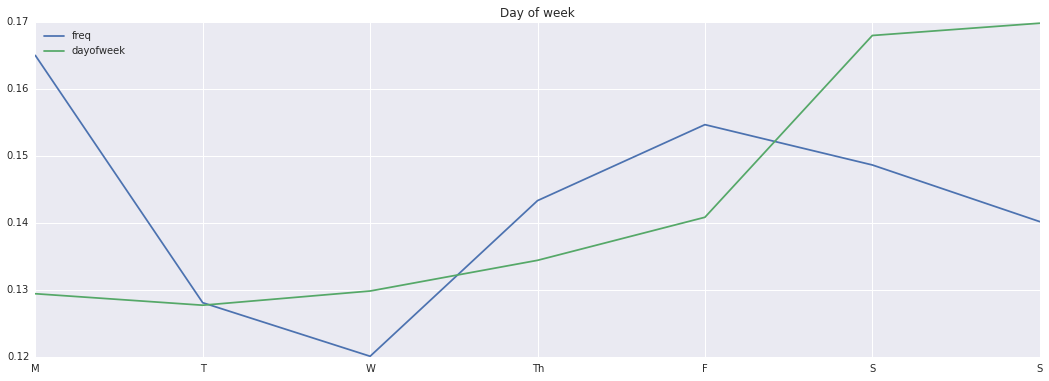

In [517]:
dayofweek.index = ["M", "T", "W", "Th", "F", "S", "S"]
freq.index = ["M", "T", "W", "Th", "F", "S", "S"]

temp = pd.concat([freq, dayofweek], axis=1)
temp.columns = ["freq", "dayofweek"]
temp.plot(title="Day of week", figsize=(18, 6))

In [523]:
hour = (
    df.prediction_firstperson_svc.groupby(df.index.hour).agg("mean") * 
    df.prediction_alcohol_svc.groupby(df.index.hour).agg("mean")
)
hour /= hour.sum()

freq = df.o.groupby(df.index.hour).agg("sum") 
freq /= freq.sum()

temp = pd.concat([freq, hour], axis=1)

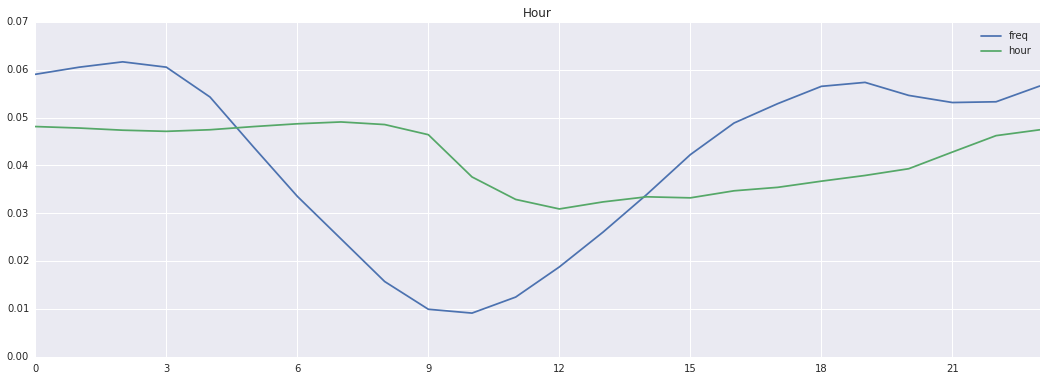

In [529]:
temp.columns = ["freq", "hour"]
temp.plot(title="Hour", xticks=[3*x for x in range(24//3)], figsize=(18, 6))

In [382]:
fp = pd.DataFrame([
 df.prediction_firstperson_level_0.groupby(df.index.hour).agg("mean"),
 df.prediction_firstperson_level_2.groupby(df.index.hour).agg("mean"),
 df.prediction_firstperson_level_3.groupby(df.index.hour).agg("mean")]).T
fp.columns = ["casual", "looking", "reflecting"]

for c in fp.columns: fp[c] = (fp[c] * hour) / (fp[c] * hour).sum()

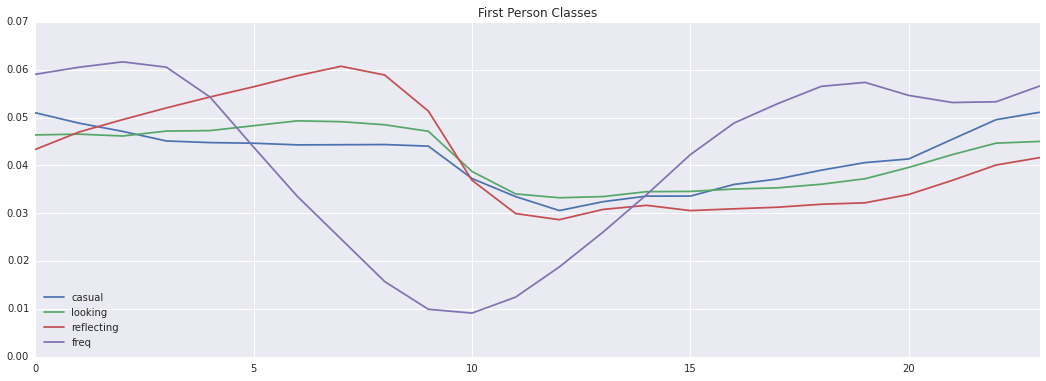

In [530]:
fp["freq"] = freq

fp.plot(title="First Person Classes", figsize=(18, 6))

In [531]:
dayhour = (
    df.prediction_firstperson_svc.groupby([df.index.dayofweek, df.index.hour]).agg("mean") * 
    df.prediction_alcohol_svc.groupby([df.index.dayofweek, df.index.hour]).agg("mean")
)
dayhour /= dayhour.sum()

freq = df.o.groupby([df.index.dayofweek, df.index.hour]).agg("sum")
freq /= freq.sum()

freq.index.levels = [["M", "T", "W", "Th", "F", "S", "S"], list(range(24))]
dayhour.index.levels = [["M", "T", "W", "Th", "F", "S", "S"], list(range(24))]

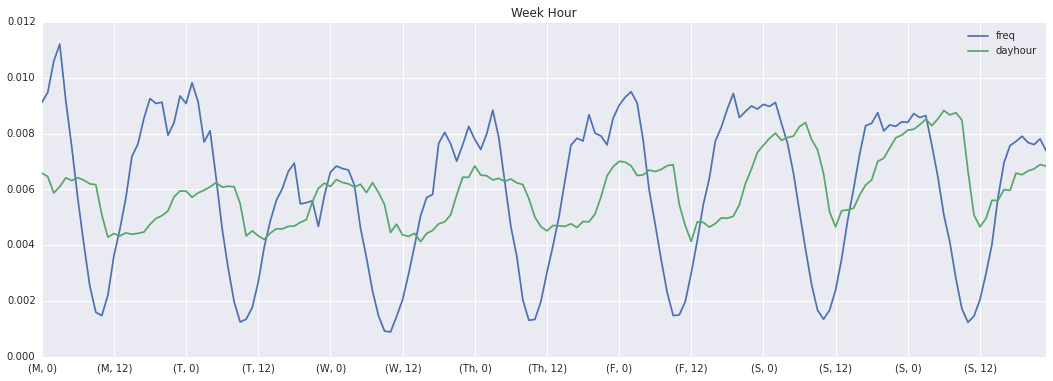

In [532]:
temp = pd.concat([freq, dayhour], axis=1)
temp.columns = ["freq", "dayhour"]

temp.plot(xticks=[_ for _ in range(24*7) if _%12==0], figsize=(18, 6), title="Week Hour")

In [421]:
fph = pd.DataFrame([
 df.prediction_firstperson_level_0.groupby([df.index.dayofweek, df.index.hour]).agg("mean"),
 df.prediction_firstperson_level_2.groupby([df.index.dayofweek, df.index.hour]).agg("mean"),
 df.prediction_firstperson_level_3.groupby([df.index.dayofweek, df.index.hour]).agg("mean")]).T

fph.columns = ["casual", "looking", "reflecting"]
fph.index.levels = [["M", "T", "W", "Th", "F", "S", "S"], list(range(24))]

for c in fph.columns: fph[c] = (fph[c] * dayhour) / (fph[c] * dayhour).sum()

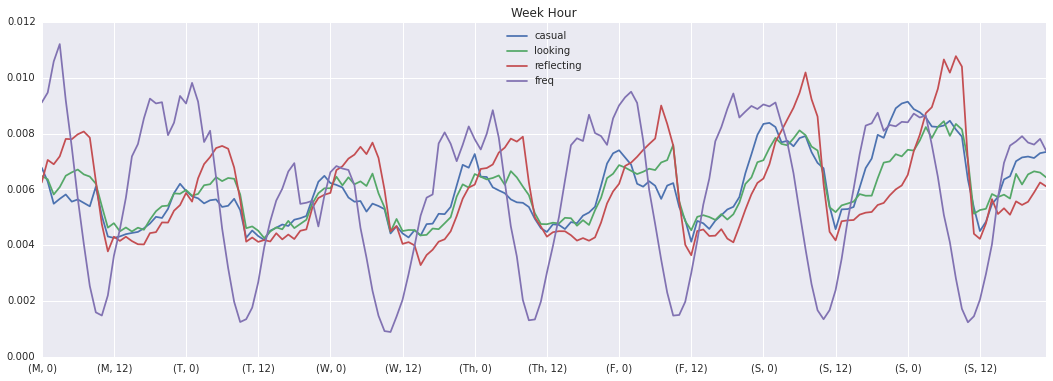

In [533]:
bjjfph["freq"] = freq

fph.plot(xticks=[_ for _ in range(24*7) if _%12==0], figsize=(18, 6), title="Week Hour")

# Take a look at how we can define point estimates for our time series.

# sort users by frequency of alcohol related posts

In [546]:
look at fp vs fp

,created_at,geo,place_country,place_fullname,source,user_favourites_count,user_followers_count,user_friends_count,user_id,user_screen_name,user_statuses_count,prediction_alcohol_svc,prediction_firstperson_svc,prediction_firstperson_level_0,prediction_firstperson_level_2,prediction_firstperson_level_3,o
time,,,,,,,,,,,,,,,,,
2015-06-01 00:00:03,Mon Jun 01 00:00:03 +0000 2015,"{'type': 'Point', 'coordinates': [30.272005, -...",United States,"Southside, Jacksonville","<a href=""http://instagram.com"" rel=""nofollow"">...",3010,423,339,429525144,sarahbourgade,1233,0.131904,0.523643,0.616766,0.367621,0.015612,1
2015-06-01 00:00:06,Mon Jun 01 00:00:06 +0000 2015,"{'type': 'Point', 'coordinates': [40.696258, -...",United States,"Brooklyn, NY","<a href=""http://dlvr.it"" rel=""nofollow"">dlvr.i...",0,1418,289,2864110470,wasnewscom,24906,0.500000,0.500000,0.993748,0.001718,0.004534,1
2015-06-01 00:00:07,Mon Jun 01 00:00:07 +0000 2015,"{'type': 'Point', 'coordinates': [34.059747, -...",United States,"Los Angeles, CA","<a href=""http://instagram.com"" rel=""nofollow"">...",39,547,1077,88216570,Gillishir,1358,0.629574,0.549015,0.957055,0.041217,0.001728,1
2015-06-01 00:00:09,Mon Jun 01 00:00:09 +0000 2015,None,United States,"Fontana, CA","<a href=""http://twitter.com/download/android"" ...",7011,1346,842,226336956,danelleee__,45361,0.114825,0.665164,0.052188,0.101156,0.846657,1
2015-06-01 00:00:09,Mon Jun 01 00:00:09 +0000 2015,None,United States,"West Hollywood, CA","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",345,2635,1293,484324340,Barihunks,2940,0.119263,0.431844,0.564079,0.430679,0.005242,1
2015-06-01 00:00:09,Mon Jun 01 00:00:09 +0000 2015,"{'type': 'Point', 'coordinates': [40.721674, -...",United States,"Manhattan, NY","<a href=""http://instagram.com"" rel=""nofollow"">...",22008,310,204,240509008,jma9999,24623,0.669641,0.720710,0.763088,0.183427,0.053485,1
2015-06-01 00:00:10,Mon Jun 01 00:00:10 +0000 2015,"{'type': 'Point', 'coordinates': [41.878114, -...",United States,"Chicago, IL","<a href=""http://tweetmyjobs.com"" rel=""nofollow...",352,11779,62,73210851,UPJobs,1130,0.099418,0.419171,0.535084,0.452904,0.012011,1
2015-06-01 00:00:11,Mon Jun 01 00:00:11 +0000 2015,None,United States,"Pennsylvania, USA","<a href=""http://twitter.com/download/iphone"" r...",26308,523,635,246623929,amandaafasanz,33225,0.073645,0.463928,0.037242,0.255653,0.707105,1
2015-06-01 00:00:20,Mon Jun 01 00:00:20 +0000 2015,None,United States,"Michigan, USA","<a href=""http://twitter.com/download/android"" ...",4742,626,559,2393114262,cjgrowstrees,3696,0.445010,0.500000,0.019870,0.014724,0.965406,1


In [ ]:
df

In [ ]:
df.groupby("user_id").agg({
    "o":"sum",
    "prediction_alcohol_svc": lambda _: (_>0.5).mean(),
    "prediction_firstperson_svc": lambda _: (_>0.5).mean()}
).sort("o", ascending=0)